# Dog Breed Classification using CNN

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools

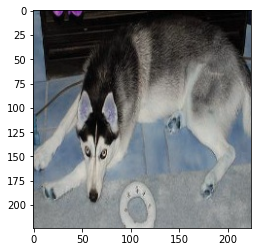

In [2]:
siberianhusky = cv2.imread('../../input/dataset-gerry-70-dog-breeds/train/Siberian Husky/01.jpg')
siberianhusky.shape
plt.imshow(siberianhusky)

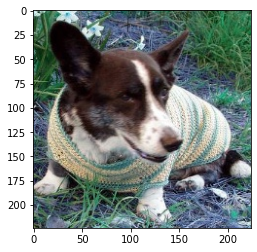

In [3]:
corgi = cv2.imread('../../input/dataset-gerry-70-dog-breeds/train/Corgi/001.jpg')
corgi.shape
plt.imshow(corgi)

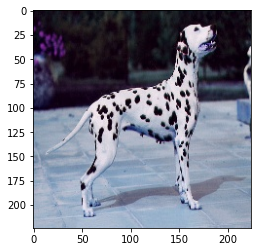

In [4]:
dalmation = cv2.imread('../../input/dataset-gerry-70-dog-breeds/train/Dalmation/01.jpg')
dalmation.shape
plt.imshow(dalmation)

In [5]:
class_folder_paths = ['../../input/dataset-gerry-70-dog-breeds/test/'+x for x in os.listdir('../../input/dataset-gerry-70-dog-breeds/test/')]
class_folder_paths

['../../input/dataset-gerry-70-dog-breeds/test/Afghan',
 '../../input/dataset-gerry-70-dog-breeds/test/African Wild Dog',
 '../../input/dataset-gerry-70-dog-breeds/test/Airedale',
 '../../input/dataset-gerry-70-dog-breeds/test/American Hairless',
 '../../input/dataset-gerry-70-dog-breeds/test/American Spaniel',
 '../../input/dataset-gerry-70-dog-breeds/test/Basenji',
 '../../input/dataset-gerry-70-dog-breeds/test/Basset',
 '../../input/dataset-gerry-70-dog-breeds/test/Beagle',
 '../../input/dataset-gerry-70-dog-breeds/test/Bearded Collie',
 '../../input/dataset-gerry-70-dog-breeds/test/Bermaise',
 '../../input/dataset-gerry-70-dog-breeds/test/Bichon Frise',
 '../../input/dataset-gerry-70-dog-breeds/test/Blenheim',
 '../../input/dataset-gerry-70-dog-breeds/test/Bloodhound',
 '../../input/dataset-gerry-70-dog-breeds/test/Bluetick',
 '../../input/dataset-gerry-70-dog-breeds/test/Border Collie',
 '../../input/dataset-gerry-70-dog-breeds/test/Borzoi',
 '../../input/dataset-gerry-70-dog-bree

#### check the number of images per class

In [6]:
for class_folder_path in class_folder_paths:
    print('{0}:'.format(class_folder_path), ' ', len(os.listdir(class_folder_path)))

../../input/dataset-gerry-70-dog-breeds/test/Afghan:   10
../../input/dataset-gerry-70-dog-breeds/test/African Wild Dog:   10
../../input/dataset-gerry-70-dog-breeds/test/Airedale:   10
../../input/dataset-gerry-70-dog-breeds/test/American Hairless:   10
../../input/dataset-gerry-70-dog-breeds/test/American Spaniel:   10
../../input/dataset-gerry-70-dog-breeds/test/Basenji:   10
../../input/dataset-gerry-70-dog-breeds/test/Basset:   10
../../input/dataset-gerry-70-dog-breeds/test/Beagle:   10
../../input/dataset-gerry-70-dog-breeds/test/Bearded Collie:   10
../../input/dataset-gerry-70-dog-breeds/test/Bermaise:   10
../../input/dataset-gerry-70-dog-breeds/test/Bichon Frise:   10
../../input/dataset-gerry-70-dog-breeds/test/Blenheim:   10
../../input/dataset-gerry-70-dog-breeds/test/Bloodhound:   10
../../input/dataset-gerry-70-dog-breeds/test/Bluetick:   10
../../input/dataset-gerry-70-dog-breeds/test/Border Collie:   10
../../input/dataset-gerry-70-dog-breeds/test/Borzoi:   10
../../i

## Model Building

In [7]:
train_path = '../../input/dataset-gerry-70-dog-breeds/train'
valid_path = '../../input/dataset-gerry-70-dog-breeds/valid'
test_path = '../../input/dataset-gerry-70-dog-breeds/test'

train_batch_size = 10
val_batch_size = 10
image_size = 224

### Data Preprocessing

In [8]:
datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [9]:
num_train_samples = 7946
num_val_samples = 700

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

### modify mobilenet model

In [10]:
# create a copy of a mobilenet model

mobile = tf.keras.applications.mobilenet.MobileNet()

In [11]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [12]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 70 corresponds to the number of classes (units)
x = Dropout(0.25)(x) # 0.25 = rate
predictions = Dense(70, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the dense layer created above.
model = Model(inputs=mobile.input, outputs=predictions)

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [14]:
# choose how many layers that's actually want to be trained.

# Here we are freezing the weights of all layers except the last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

### Training the model

In [15]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [16]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'Afghan': 0, 'African Wild Dog': 1, 'Airedale': 2, 'American Hairless': 3, 'American Spaniel': 4, 'Basenji': 5, 'Basset': 6, 'Beagle': 7, 'Bearded Collie': 8, 'Bermaise': 9, 'Bichon Frise': 10, 'Blenheim': 11, 'Bloodhound': 12, 'Bluetick': 13, 'Border Collie': 14, 'Borzoi': 15, 'Boston Terrier': 16, 'Boxer': 17, 'Bull Mastiff': 18, 'Bull Terrier': 19, 'Bulldog': 20, 'Cairn': 21, 'Chihuahua': 22, 'Chinese Crested': 23, 'Chow': 24, 'Clumber': 25, 'Cockapoo': 26, 'Cocker': 27, 'Collie': 28, 'Corgi': 29, 'Coyote': 30, 'Dalmation': 31, 'Dhole': 32, 'Dingo': 33, 'Doberman': 34, 'Elk Hound': 35, 'French Bulldog': 36, 'German Sheperd': 37, 'Golden Retriever': 38, 'Great Dane': 39, 'Great Perenees': 40, 'Greyhound': 41, 'Groenendael': 42, 'Irish Spaniel': 43, 'Irish Wolfhound': 44, 'Japanese Spaniel': 45, 'Komondor': 46, 'Labradoodle': 47, 'Labrador': 48, 'Lhasa': 49, 'Malinois': 50, 'Maltese': 51, 'Mex Hairless': 52, 'Newfoundland': 53, 'Pekinese': 54, 'Pit Bull': 55, 'Pomeranian': 56, 'Poodl

## Percobaan 1 (LR 0.01, Epoch 10)

In [36]:
model.compile(Adam(lr=0.01), loss='mse', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [37]:
filepath = "model_lr1e-2_e10.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                              verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/10
795/795 [==============================] - ETA: 0s - loss: 0.0146 - categorical_accuracy: 0.1377 - top_2_accuracy: 0.1934 - top_3_accuracy: 0.2293
Epoch 00001: val_top_3_accuracy improved from -inf to 0.10714, saving model to model_lr1e-2_e10.h5
795/795 [==============================] - 286s 360ms/step - loss: 0.0146 - categorical_accuracy: 0.1377 - top_2_accuracy: 0.1934 - top_3_accuracy: 0.2293 - val_loss: 0.0185 - val_categorical_accuracy: 0.0671 - val_top_2_accuracy: 0.0871 - val_top_3_accuracy: 0.1071
Epoch 2/10
795/795 [==============================] - ETA: 0s - loss: 0.0119 - categorical_accuracy: 0.3044 - top_2_accuracy: 0.4013 - top_3_accuracy: 0.4621
Epoch 00002: val_top_3_accuracy improved from 0.10714 to 0.60000, saving model to model_lr1e-2_e10.h5
795/795 [==============================] - 285s 358ms/step - loss: 0.0119 - categorical_accuracy: 0.3044 - top_2_accuracy: 0.4013 - top_3_accuracy: 0.4621 - val_loss: 0.0110 - val_categorical_accuracy: 0.4057 - val_t

### Evaluate the model using the val set

In [38]:
# get the metric names so we can use evaluate
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [39]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 20s 28ms/step - loss: 0.0027 - categorical_accuracy: 0.8771 - top_2_accuracy: 0.9600 - top_3_accuracy: 0.9786
val_loss: 0.0026894945185631514
val_cat_acc: 0.8771428465843201
val_top_2_acc: 0.9599999785423279
val_top_3_acc: 0.9785714149475098


In [40]:
# Here the best epoch will be used.

model.load_weights('model_mse_5.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 20s 28ms/step - loss: 0.0026 - categorical_accuracy: 0.8800 - top_2_accuracy: 0.9571 - top_3_accuracy: 0.9843
val_loss: 0.0025798690039664507
val_cat_acc: 0.8799999952316284
val_top_2_acc: 0.9571428298950195
val_top_3_acc: 0.9842857122421265


### Plot the Training Curves

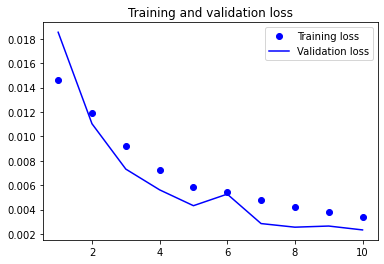

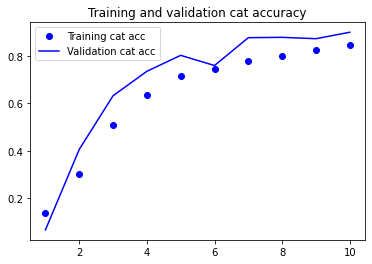

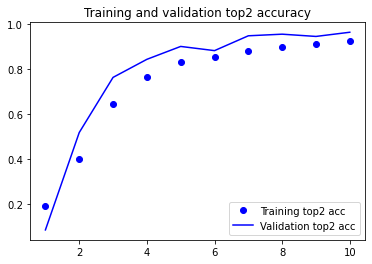

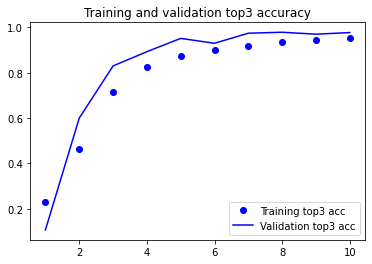

In [41]:
# display the loss and accuracy curves

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [42]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [43]:
# We need these to plot the confusion matrix.
test_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [44]:
# Print the label associated with each class
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

In [45]:
# make a prediction
predictions = model.predict(test_batches, steps=700, verbose=1)

700/700 [==============================] - 20s 28ms/step


In [46]:
predictions.shape

(700, 70)

In [47]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [48]:
test_labels.shape

(700,)

In [49]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [50]:
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

Confusion matrix, without normalization
[[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  7]]


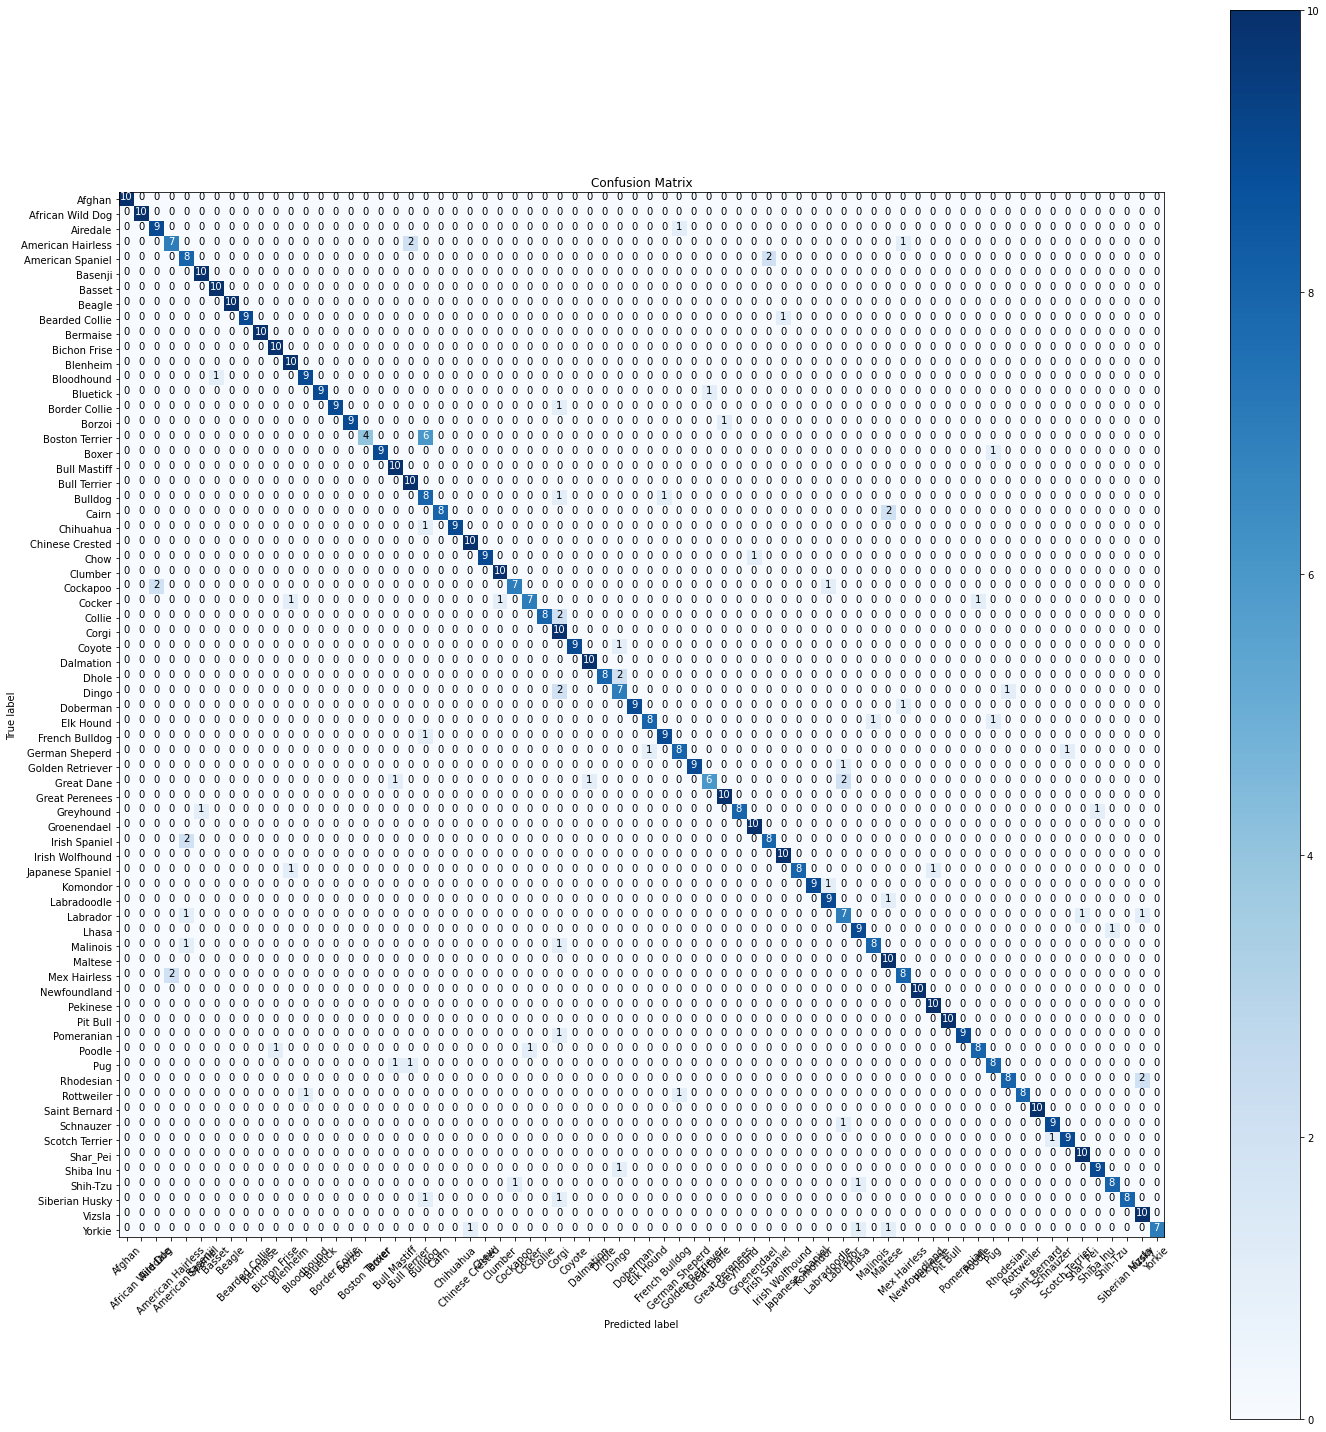

In [51]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Afghan','African Wild Dog','Airedale','American Hairless','American Spaniel','Basenji','Basset','Beagle','Bearded Collie','Bermaise','Bichon Frise','Blenheim','Bloodhound','Bluetick','Border Collie','Borzoi','Boston Terrier','Boxer','Bull Mastiff','Bull Terrier','Bulldog','Cairn','Chihuahua','Chinese Crested','Chow','Clumber','Cockapoo','Cocker','Collie','Corgi','Coyote','Dalmation','Dhole','Dingo','Doberman','Elk Hound','French Bulldog','German Sheperd','Golden Retriever','Great Dane','Great Perenees','Greyhound','Groenendael','Irish Spaniel','Irish Wolfhound','Japanese Spaniel','Komondor','Labradoodle','Labrador','Lhasa','Malinois','Maltese','Mex Hairless','Newfoundland','Pekinese','Pit Bull','Pomeranian','Poodle','Pug','Rhodesian','Rottweiler','Saint Bernard','Schnauzer','Scotch Terrier','Shar_Pei','Shiba Inu','Shih-Tzu','Siberian Husky','Vizsla','Yorkie']
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [52]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [53]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

                   precision    recall  f1-score   support

           Afghan       1.00      1.00      1.00        10
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       0.82      0.90      0.86        10
American Hairless       0.78      0.70      0.74        10
 American Spaniel       0.67      0.80      0.73        10
          Basenji       0.91      1.00      0.95        10
           Basset       0.91      1.00      0.95        10
           Beagle       1.00      1.00      1.00        10
   Bearded Collie       1.00      0.90      0.95        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       0.91      1.00      0.95        10
         Blenheim       0.83      1.00      0.91        10
       Bloodhound       0.90      0.90      0.90        10
         Bluetick       1.00      0.90      0.95        10
    Border Collie       1.00      0.90      0.95        10
           Borzoi       1.00      0.90      0.95       

<b>Recall</b> = Given a class, will the classifier be able to detect it?<br>
<b>Precision</b> = Given a class prediction from a classifier, how likely is it to be correct?<br>
<b>F1 Score</b> = The harmonic mean of the recall and precision. Essentially, it punishes extreme values

## Percobaan 2 (LR 0.01, Epoch 15)

In [83]:
model.compile(Adam(lr=0.01), loss='mse', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [84]:
filepath = "model_lr1e-2_e15.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=15, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/15
795/795 [==============================] - ETA: 0s - loss: 0.0029 - categorical_accuracy: 0.8629 - top_2_accuracy: 0.9417 - top_3_accuracy: 0.9615
Epoch 00001: val_top_3_accuracy improved from -inf to 0.98714, saving model to model_lr1e-2_e15.h5
795/795 [==============================] - 305s 384ms/step - loss: 0.0029 - categorical_accuracy: 0.8629 - top_2_accuracy: 0.9417 - top_3_accuracy: 0.9615 - val_loss: 0.0024 - val_categorical_accuracy: 0.9000 - val_top_2_accuracy: 0.9714 - val_top_3_accuracy: 0.9871
Epoch 2/15
795/795 [==============================] - ETA: 0s - loss: 0.0029 - categorical_accuracy: 0.8627 - top_2_accuracy: 0.9382 - top_3_accuracy: 0.9630
Epoch 00002: val_top_3_accuracy did not improve from 0.98714
795/795 [==============================] - 310s 390ms/step - loss: 0.0029 - categorical_accuracy: 0.8627 - top_2_accuracy: 0.9382 - top_3_accuracy: 0.9630 - val_loss: 0.0026 - val_categorical_accuracy: 0.8857 - val_top_2_accuracy: 0.9700 - val_top_3_accurac

### Evaluate the model using the val set

In [85]:
# get the metric names so we can use evaluate
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [86]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 21s 30ms/step - loss: 0.0015 - categorical_accuracy: 0.9300 - top_2_accuracy: 0.9871 - top_3_accuracy: 0.9914
val_loss: 0.0015331945614889264
val_cat_acc: 0.9300000071525574
val_top_2_acc: 0.9871428608894348
val_top_3_acc: 0.991428554058075


In [87]:
# Here the best epoch will be used.

model.load_weights('model_lr1e-2_e15.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 22s 32ms/step - loss: 0.0016 - categorical_accuracy: 0.9329 - top_2_accuracy: 0.9886 - top_3_accuracy: 0.9914
val_loss: 0.0015730783343315125
val_cat_acc: 0.9328571557998657
val_top_2_acc: 0.9885714054107666
val_top_3_acc: 0.991428554058075


### Plot the Training Curves

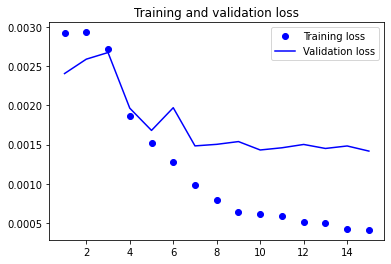

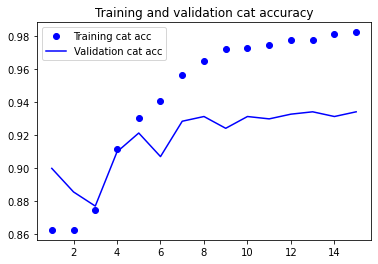

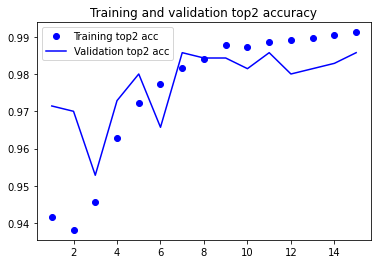

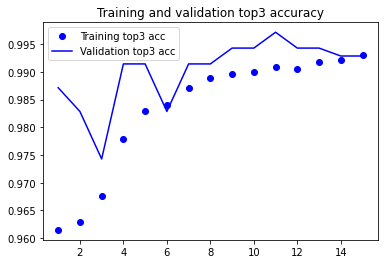

In [88]:
# display the loss and accuracy curves

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [89]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [90]:
# We need these to plot the confusion matrix.
test_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [91]:
# Print the label associated with each class
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

In [92]:
# make a prediction
predictions = model.predict(test_batches, steps=700, verbose=1)

700/700 [==============================] - 22s 31ms/step


In [93]:
predictions.shape

(700, 70)

In [94]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [95]:
test_labels.shape

(700,)

In [96]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [97]:
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

Confusion matrix, without normalization
[[ 9  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]


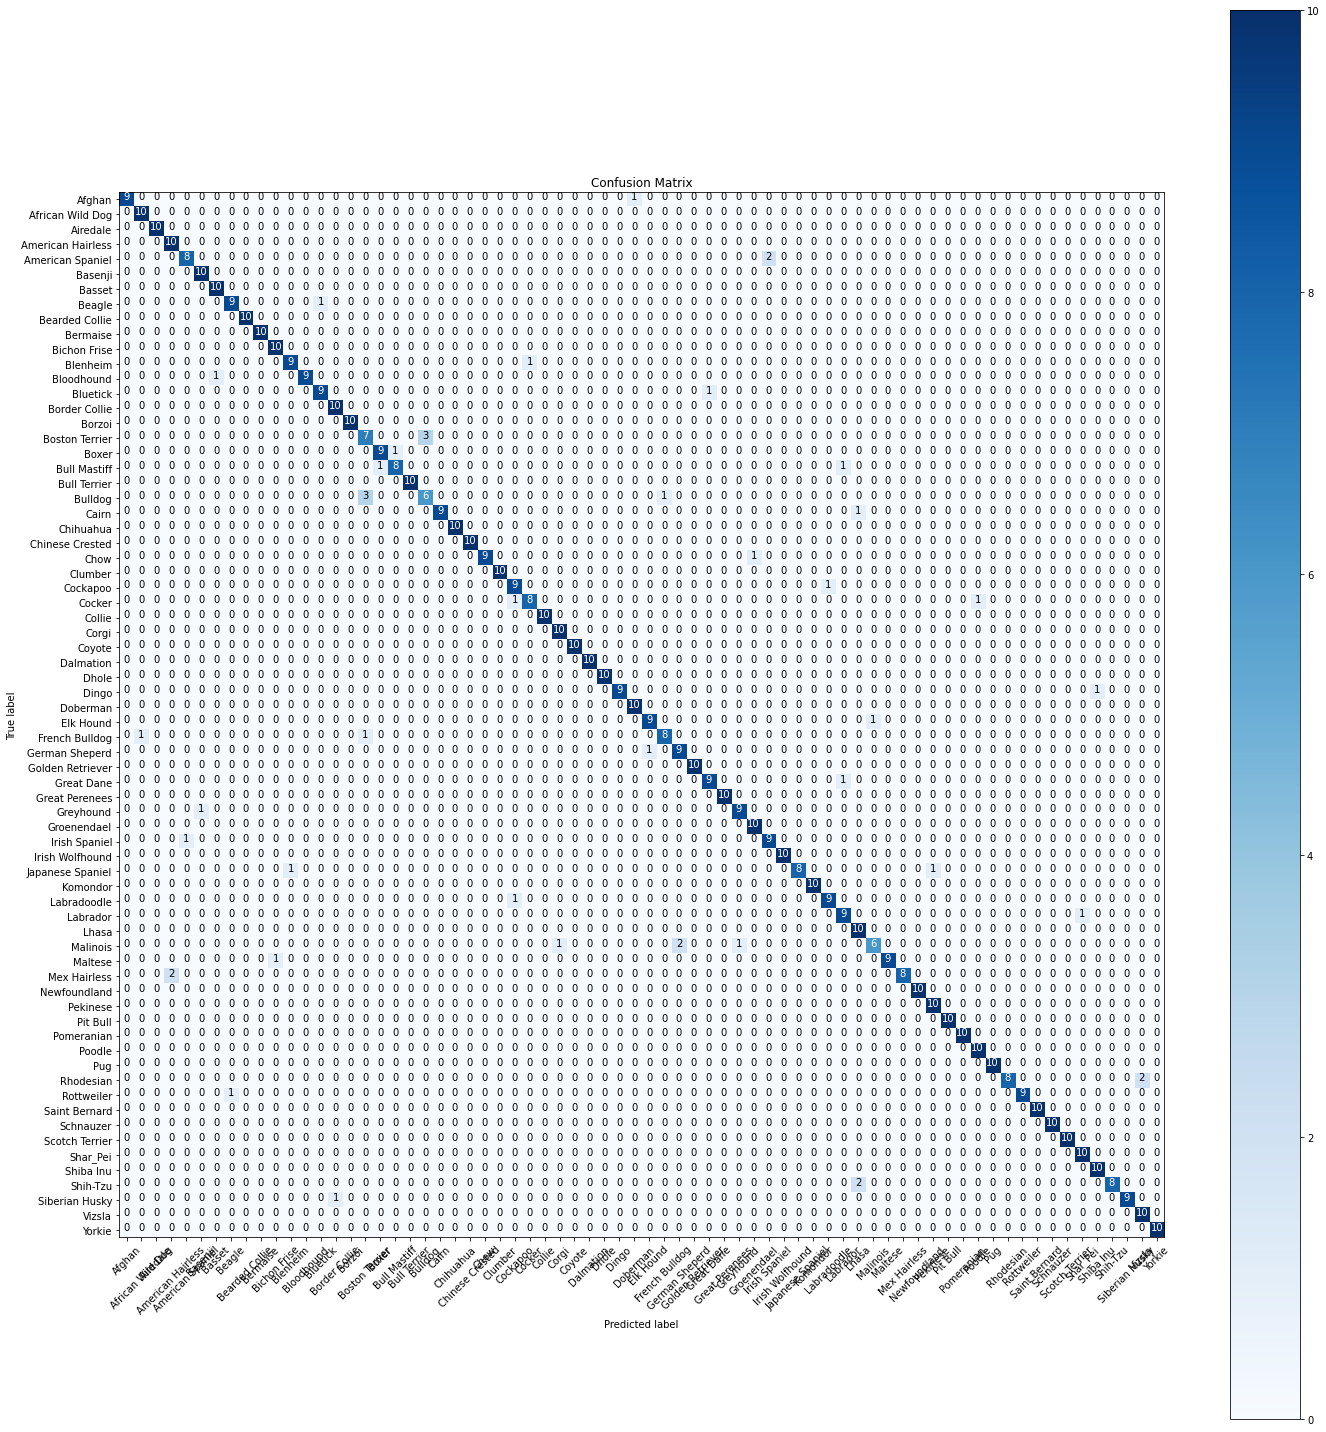

In [98]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Afghan','African Wild Dog','Airedale','American Hairless','American Spaniel','Basenji','Basset','Beagle','Bearded Collie','Bermaise','Bichon Frise','Blenheim','Bloodhound','Bluetick','Border Collie','Borzoi','Boston Terrier','Boxer','Bull Mastiff','Bull Terrier','Bulldog','Cairn','Chihuahua','Chinese Crested','Chow','Clumber','Cockapoo','Cocker','Collie','Corgi','Coyote','Dalmation','Dhole','Dingo','Doberman','Elk Hound','French Bulldog','German Sheperd','Golden Retriever','Great Dane','Great Perenees','Greyhound','Groenendael','Irish Spaniel','Irish Wolfhound','Japanese Spaniel','Komondor','Labradoodle','Labrador','Lhasa','Malinois','Maltese','Mex Hairless','Newfoundland','Pekinese','Pit Bull','Pomeranian','Poodle','Pug','Rhodesian','Rottweiler','Saint Bernard','Schnauzer','Scotch Terrier','Shar_Pei','Shiba Inu','Shih-Tzu','Siberian Husky','Vizsla','Yorkie']
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [99]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [100]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

                   precision    recall  f1-score   support

           Afghan       1.00      0.90      0.95        10
 African Wild Dog       0.91      1.00      0.95        10
         Airedale       1.00      1.00      1.00        10
American Hairless       0.83      1.00      0.91        10
 American Spaniel       0.89      0.80      0.84        10
          Basenji       0.91      1.00      0.95        10
           Basset       0.91      1.00      0.95        10
           Beagle       0.90      0.90      0.90        10
   Bearded Collie       1.00      1.00      1.00        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       0.91      1.00      0.95        10
         Blenheim       0.90      0.90      0.90        10
       Bloodhound       1.00      0.90      0.95        10
         Bluetick       0.90      0.90      0.90        10
    Border Collie       0.91      1.00      0.95        10
           Borzoi       1.00      1.00      1.00       

## Percobaan 3 (LR 0.001, Epoch 10)

In [54]:
model.compile(Adam(lr=0.001), loss='mse', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [55]:
filepath = "model_lr1e-3_e10.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/10
795/795 [==============================] - ETA: 0s - loss: 0.0027 - categorical_accuracy: 0.8719 - top_2_accuracy: 0.9395 - top_3_accuracy: 0.9581
Epoch 00001: val_top_3_accuracy improved from -inf to 0.99143, saving model to model_lr1e-3_e10.h5
795/795 [==============================] - 284s 358ms/step - loss: 0.0027 - categorical_accuracy: 0.8719 - top_2_accuracy: 0.9395 - top_3_accuracy: 0.9581 - val_loss: 0.0018 - val_categorical_accuracy: 0.9129 - val_top_2_accuracy: 0.9800 - val_top_3_accuracy: 0.9914
Epoch 2/10
795/795 [==============================] - ETA: 0s - loss: 0.0022 - categorical_accuracy: 0.8979 - top_2_accuracy: 0.9537 - top_3_accuracy: 0.9693
Epoch 00002: val_top_3_accuracy improved from 0.99143 to 0.99429, saving model to model_lr1e-3_e10.h5
795/795 [==============================] - 284s 357ms/step - loss: 0.0022 - categorical_accuracy: 0.8979 - top_2_accuracy: 0.9537 - top_3_accuracy: 0.9693 - val_loss: 0.0017 - val_categorical_accuracy: 0.9186 - val_t

### Evaluate the model using the val set

In [56]:
# get the metric names so we can use model.evaluate
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [57]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 20s 28ms/step - loss: 0.0015 - categorical_accuracy: 0.9229 - top_2_accuracy: 0.9800 - top_3_accuracy: 0.99290s - loss: 0.0016 - categorical_accuracy: 0.9208 - top_2_accuracy: 0.9795 - to
val_loss: 0.0015317974612116814
val_cat_acc: 0.9228571653366089
val_top_2_acc: 0.9800000190734863
val_top_3_acc: 0.9928571581840515


In [58]:
# Here the best epoch will be used.

model.load_weights('model_lr1e-3_e10.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 20s 28ms/step - loss: 0.0015 - categorical_accuracy: 0.9271 - top_2_accuracy: 0.9771 - top_3_accuracy: 0.9929
val_loss: 0.0015483524184674025
val_cat_acc: 0.927142858505249
val_top_2_acc: 0.977142870426178
val_top_3_acc: 0.9928571581840515


### Plot the Training Curves

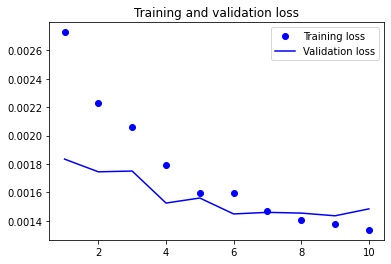

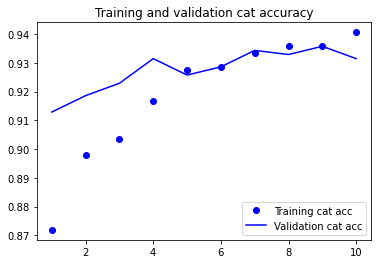

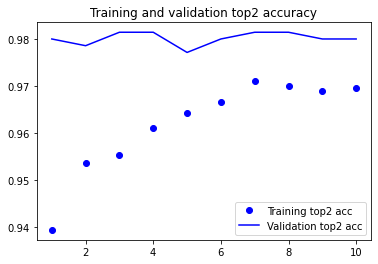

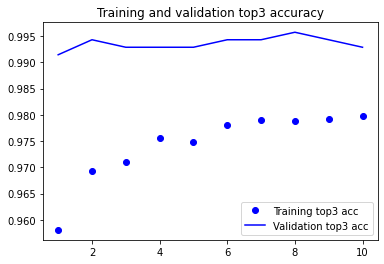

In [59]:
# display the loss and accuracy curves

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [60]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [61]:
# We need these to plot the confusion matrix.
test_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [62]:
# Print the label associated with each class
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

In [63]:
# make a prediction
predictions = model.predict(test_batches, steps=700, verbose=1)

700/700 [==============================] - 20s 28ms/step


In [64]:
predictions.shape

(700, 70)

In [65]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [66]:
test_labels.shape

(700,)

In [67]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [68]:
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

Confusion matrix, without normalization
[[ 9  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]


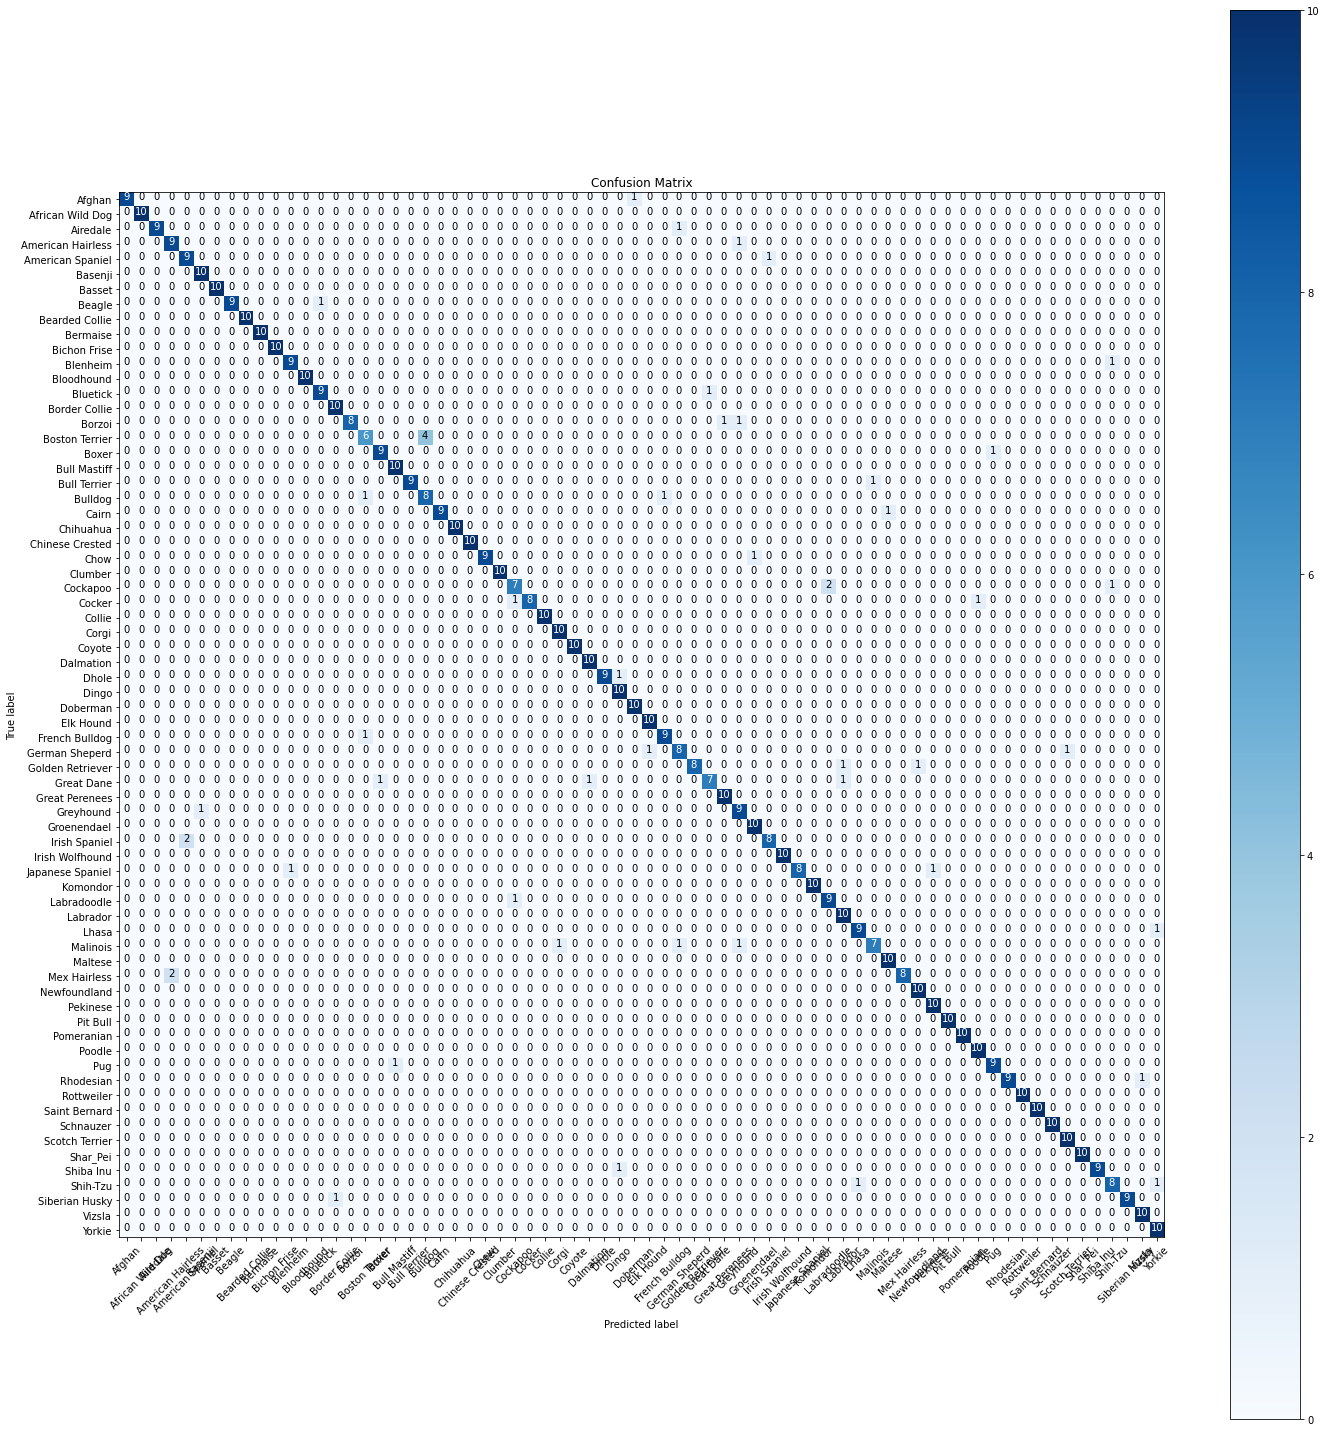

In [69]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Afghan','African Wild Dog','Airedale','American Hairless','American Spaniel','Basenji','Basset','Beagle','Bearded Collie','Bermaise','Bichon Frise','Blenheim','Bloodhound','Bluetick','Border Collie','Borzoi','Boston Terrier','Boxer','Bull Mastiff','Bull Terrier','Bulldog','Cairn','Chihuahua','Chinese Crested','Chow','Clumber','Cockapoo','Cocker','Collie','Corgi','Coyote','Dalmation','Dhole','Dingo','Doberman','Elk Hound','French Bulldog','German Sheperd','Golden Retriever','Great Dane','Great Perenees','Greyhound','Groenendael','Irish Spaniel','Irish Wolfhound','Japanese Spaniel','Komondor','Labradoodle','Labrador','Lhasa','Malinois','Maltese','Mex Hairless','Newfoundland','Pekinese','Pit Bull','Pomeranian','Poodle','Pug','Rhodesian','Rottweiler','Saint Bernard','Schnauzer','Scotch Terrier','Shar_Pei','Shiba Inu','Shih-Tzu','Siberian Husky','Vizsla','Yorkie']
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [70]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [71]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

                   precision    recall  f1-score   support

           Afghan       1.00      0.90      0.95        10
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       1.00      0.90      0.95        10
American Hairless       0.82      0.90      0.86        10
 American Spaniel       0.82      0.90      0.86        10
          Basenji       0.91      1.00      0.95        10
           Basset       1.00      1.00      1.00        10
           Beagle       1.00      0.90      0.95        10
   Bearded Collie       1.00      1.00      1.00        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       1.00      1.00      1.00        10
         Blenheim       0.90      0.90      0.90        10
       Bloodhound       1.00      1.00      1.00        10
         Bluetick       0.90      0.90      0.90        10
    Border Collie       0.91      1.00      0.95        10
           Borzoi       1.00      0.80      0.89       

## Percobaan 4 (LR 0.001, Epoch 15)

In [17]:
model.compile(Adam(lr=0.001), loss='mse', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [18]:
filepath = "model_lr1e-3_e15.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                              verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=15, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/15
795/795 [==============================] - ETA: 0s - loss: 0.0111 - categorical_accuracy: 0.3725 - top_2_accuracy: 0.4673 - top_3_accuracy: 0.5140
Epoch 00001: val_top_3_accuracy improved from -inf to 0.68857, saving model to model_lr1e-3_e15.h5
795/795 [==============================] - 311s 392ms/step - loss: 0.0111 - categorical_accuracy: 0.3725 - top_2_accuracy: 0.4673 - top_3_accuracy: 0.5140 - val_loss: 0.0089 - val_categorical_accuracy: 0.5471 - val_top_2_accuracy: 0.6343 - val_top_3_accuracy: 0.6886
Epoch 2/15
795/795 [==============================] - ETA: 0s - loss: 0.0065 - categorical_accuracy: 0.6739 - top_2_accuracy: 0.7810 - top_3_accuracy: 0.8227
Epoch 00002: val_top_3_accuracy improved from 0.68857 to 0.88714, saving model to model_lr1e-3_e15.h5
795/795 [==============================] - 317s 398ms/step - loss: 0.0065 - categorical_accuracy: 0.6739 - top_2_accuracy: 0.7810 - top_3_accuracy: 0.8227 - val_loss: 0.0049 - val_categorical_accuracy: 0.7571 - val_t

### Evaluate the model using the val set

In [19]:
# get the metric names so we can use model.evaluate
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [20]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 20s 29ms/step - loss: 9.6189e-04 - categorical_accuracy: 0.9571 - top_2_accuracy: 0.9900 - top_3_accuracy: 0.9929
val_loss: 0.0009618850890547037
val_cat_acc: 0.9571428298950195
val_top_2_acc: 0.9900000095367432
val_top_3_acc: 0.9928571581840515


In [21]:
# Here the best epoch will be used.

model.load_weights('model_lr1e-3_e15.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 20s 29ms/step - loss: 9.5883e-04 - categorical_accuracy: 0.9586 - top_2_accuracy: 0.9857 - top_3_accuracy: 0.9957
val_loss: 0.0009588271495886147
val_cat_acc: 0.9585714340209961
val_top_2_acc: 0.9857142567634583
val_top_3_acc: 0.9957143068313599


### Plot the Training Curves

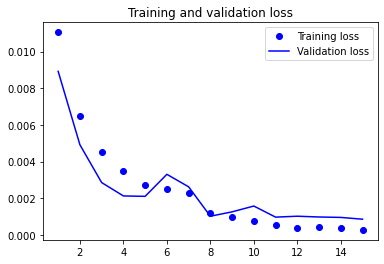

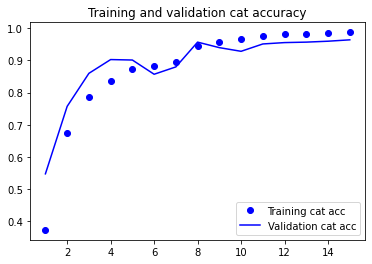

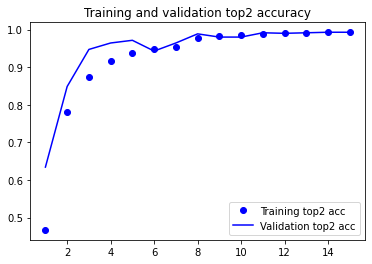

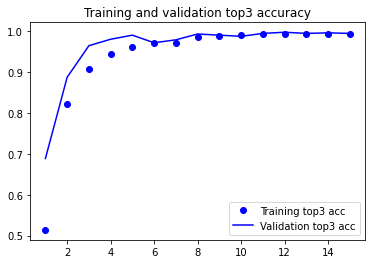

In [22]:
# display the loss and accuracy curves

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [23]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [24]:
# We need these to plot the confusion matrix.
test_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [25]:
# Print the label associated with each class
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

In [26]:
# make a prediction
predictions = model.predict(test_batches, steps=700, verbose=1)

700/700 [==============================] - 20s 29ms/step


In [27]:
predictions.shape

(700, 70)

In [28]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [29]:
test_labels.shape

(700,)

In [30]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [31]:
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

Confusion matrix, without normalization
[[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  1]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]


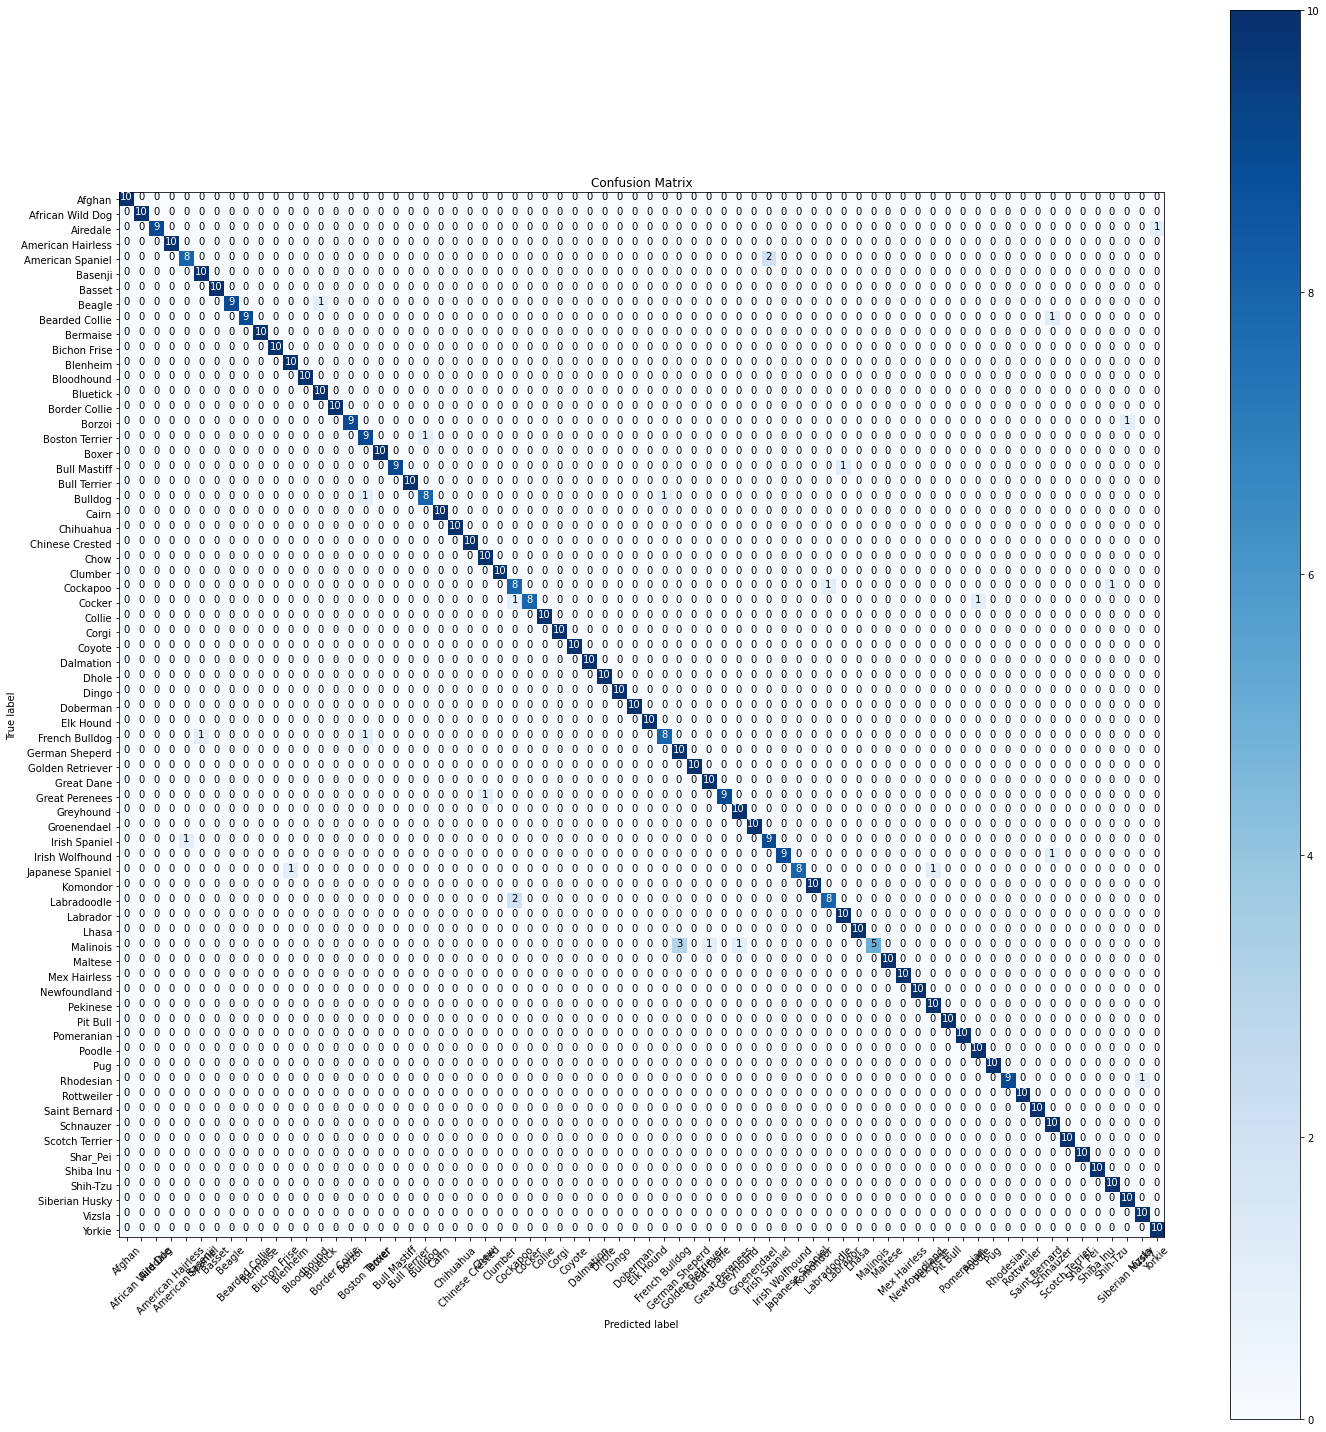

In [32]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Afghan','African Wild Dog','Airedale','American Hairless','American Spaniel','Basenji','Basset','Beagle','Bearded Collie','Bermaise','Bichon Frise','Blenheim','Bloodhound','Bluetick','Border Collie','Borzoi','Boston Terrier','Boxer','Bull Mastiff','Bull Terrier','Bulldog','Cairn','Chihuahua','Chinese Crested','Chow','Clumber','Cockapoo','Cocker','Collie','Corgi','Coyote','Dalmation','Dhole','Dingo','Doberman','Elk Hound','French Bulldog','German Sheperd','Golden Retriever','Great Dane','Great Perenees','Greyhound','Groenendael','Irish Spaniel','Irish Wolfhound','Japanese Spaniel','Komondor','Labradoodle','Labrador','Lhasa','Malinois','Maltese','Mex Hairless','Newfoundland','Pekinese','Pit Bull','Pomeranian','Poodle','Pug','Rhodesian','Rottweiler','Saint Bernard','Schnauzer','Scotch Terrier','Shar_Pei','Shiba Inu','Shih-Tzu','Siberian Husky','Vizsla','Yorkie']
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [33]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [34]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

                   precision    recall  f1-score   support

           Afghan       1.00      1.00      1.00        10
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       1.00      0.90      0.95        10
American Hairless       1.00      1.00      1.00        10
 American Spaniel       0.89      0.80      0.84        10
          Basenji       0.91      1.00      0.95        10
           Basset       1.00      1.00      1.00        10
           Beagle       1.00      0.90      0.95        10
   Bearded Collie       1.00      0.90      0.95        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       1.00      1.00      1.00        10
         Blenheim       0.91      1.00      0.95        10
       Bloodhound       1.00      1.00      1.00        10
         Bluetick       0.91      1.00      0.95        10
    Border Collie       1.00      1.00      1.00        10
           Borzoi       1.00      0.90      0.95       

In [35]:
print('val_acc:', val_acc)
print('acc:', acc)

val_acc: [0.5471428632736206, 0.7571428418159485, 0.8600000143051147, 0.9028571248054504, 0.9014285802841187, 0.8571428656578064, 0.8799999952316284, 0.9571428298950195, 0.9399999976158142, 0.9285714030265808, 0.9514285922050476, 0.9557142853736877, 0.9571428298950195, 0.9599999785423279, 0.9642857313156128]
acc: [0.3725144863128662, 0.6739239692687988, 0.7853007912635803, 0.8355147242546082, 0.8749055862426758, 0.8832116723060608, 0.8939088582992554, 0.9457588791847229, 0.9568336009979248, 0.9662723541259766, 0.9757110476493835, 0.9833878874778748, 0.9826327562332153, 0.9846463799476624, 0.9879184365272522]


## Percobaan 5 (LR 0.001, Epoch 20)

In [19]:
model.compile(Adam(lr=0.001), loss='mse', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [20]:
filepath = "model_lr1e-3_e20.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                              verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/20
795/795 [==============================] - ETA: 0s - loss: 0.0098 - categorical_accuracy: 0.4645 - top_2_accuracy: 0.5656 - top_3_accuracy: 0.6212
Epoch 00001: val_top_3_accuracy improved from -inf to 0.79571, saving model to model_lr1e-3_e20.h5
795/795 [==============================] - 297s 373ms/step - loss: 0.0098 - categorical_accuracy: 0.4645 - top_2_accuracy: 0.5656 - top_3_accuracy: 0.6212 - val_loss: 0.0077 - val_categorical_accuracy: 0.6414 - val_top_2_accuracy: 0.7500 - val_top_3_accuracy: 0.7957
Epoch 2/20
795/795 [==============================] - ETA: 0s - loss: 0.0059 - categorical_accuracy: 0.7075 - top_2_accuracy: 0.8120 - top_3_accuracy: 0.8517
Epoch 00002: val_top_3_accuracy improved from 0.79571 to 0.91286, saving model to model_lr1e-3_e20.h5
795/795 [==============================] - 288s 362ms/step - loss: 0.0059 - categorical_accuracy: 0.7075 - top_2_accuracy: 0.8120 - top_3_accuracy: 0.8517 - val_loss: 0.0052 - val_categorical_accuracy: 0.7471 - val_t

Epoch 17/20
795/795 [==============================] - ETA: 0s - loss: 2.0045e-04 - categorical_accuracy: 0.9918 - top_2_accuracy: 0.9950 - top_3_accuracy: 0.9958
Epoch 00017: val_top_3_accuracy did not improve from 1.00000
795/795 [==============================] - 287s 361ms/step - loss: 2.0045e-04 - categorical_accuracy: 0.9918 - top_2_accuracy: 0.9950 - top_3_accuracy: 0.9958 - val_loss: 9.3306e-04 - val_categorical_accuracy: 0.9557 - val_top_2_accuracy: 0.9914 - val_top_3_accuracy: 1.0000
Epoch 18/20
795/795 [==============================] - ETA: 0s - loss: 1.7259e-04 - categorical_accuracy: 0.9927 - top_2_accuracy: 0.9955 - top_3_accuracy: 0.9957
Epoch 00018: val_top_3_accuracy did not improve from 1.00000

Epoch 00018: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
795/795 [==============================] - 287s 362ms/step - loss: 1.7259e-04 - categorical_accuracy: 0.9927 - top_2_accuracy: 0.9955 - top_3_accuracy: 0.9957 - val_loss: 9.1114e-04 - val_categori

### Evaluate the model using the val set

In [21]:
# get the metric names so we can use evaluate
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [22]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 21s 30ms/step - loss: 7.6683e-04 - categorical_accuracy: 0.9657 - top_2_accuracy: 0.9914 - top_3_accuracy: 0.99716s - loss: 7.3911e-04 - categorical_accuracy: 0.9641 - t - ETA: 1s - loss: 8.1885e-04 - categorical_accura
val_loss: 0.0007668331963941455
val_cat_acc: 0.9657142758369446
val_top_2_acc: 0.991428554058075
val_top_3_acc: 0.9971428513526917


In [23]:
# Here the best epoch will be used.

model.load_weights('model_lr1e-3_e20.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 20s 28ms/step - loss: 0.0010 - categorical_accuracy: 0.9543 - top_2_accuracy: 0.9929 - top_3_accuracy: 0.9986: 18s - loss: 0.0016 - categorical_accuracy: 0.9268 - top_2_a - ETA: 15s - loss: 0.0015 - categorical_accuracy: 0.9360 - top_2_accurac - ETA: 13s - loss: 0.0012 - categorical_accuracy:  -
val_loss: 0.0010374643607065082
val_cat_acc: 0.954285740852356
val_top_2_acc: 0.9928571581840515
val_top_3_acc: 0.9985714554786682


### Plot the Training Curves

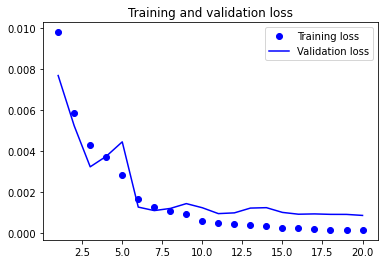

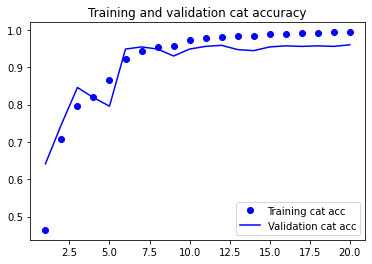

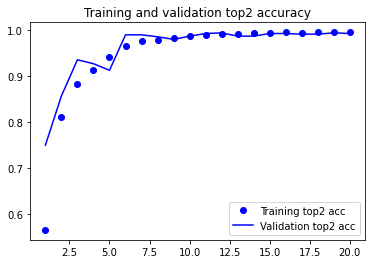

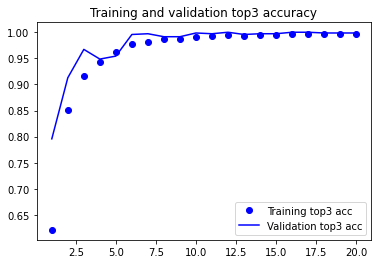

In [24]:
# display the loss and accuracy curves

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [25]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [26]:
# We need these to plot the confusion matrix.
test_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [27]:
# Print the label associated with each class
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

In [28]:
# make a prediction
predictions = model.predict(test_batches, steps=700, verbose=1)

700/700 [==============================] - 19s 28ms/step


In [29]:
predictions.shape

(700, 70)

In [30]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [31]:
test_labels.shape

(700,)

In [32]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [33]:
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

Confusion matrix, without normalization
[[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  9]]


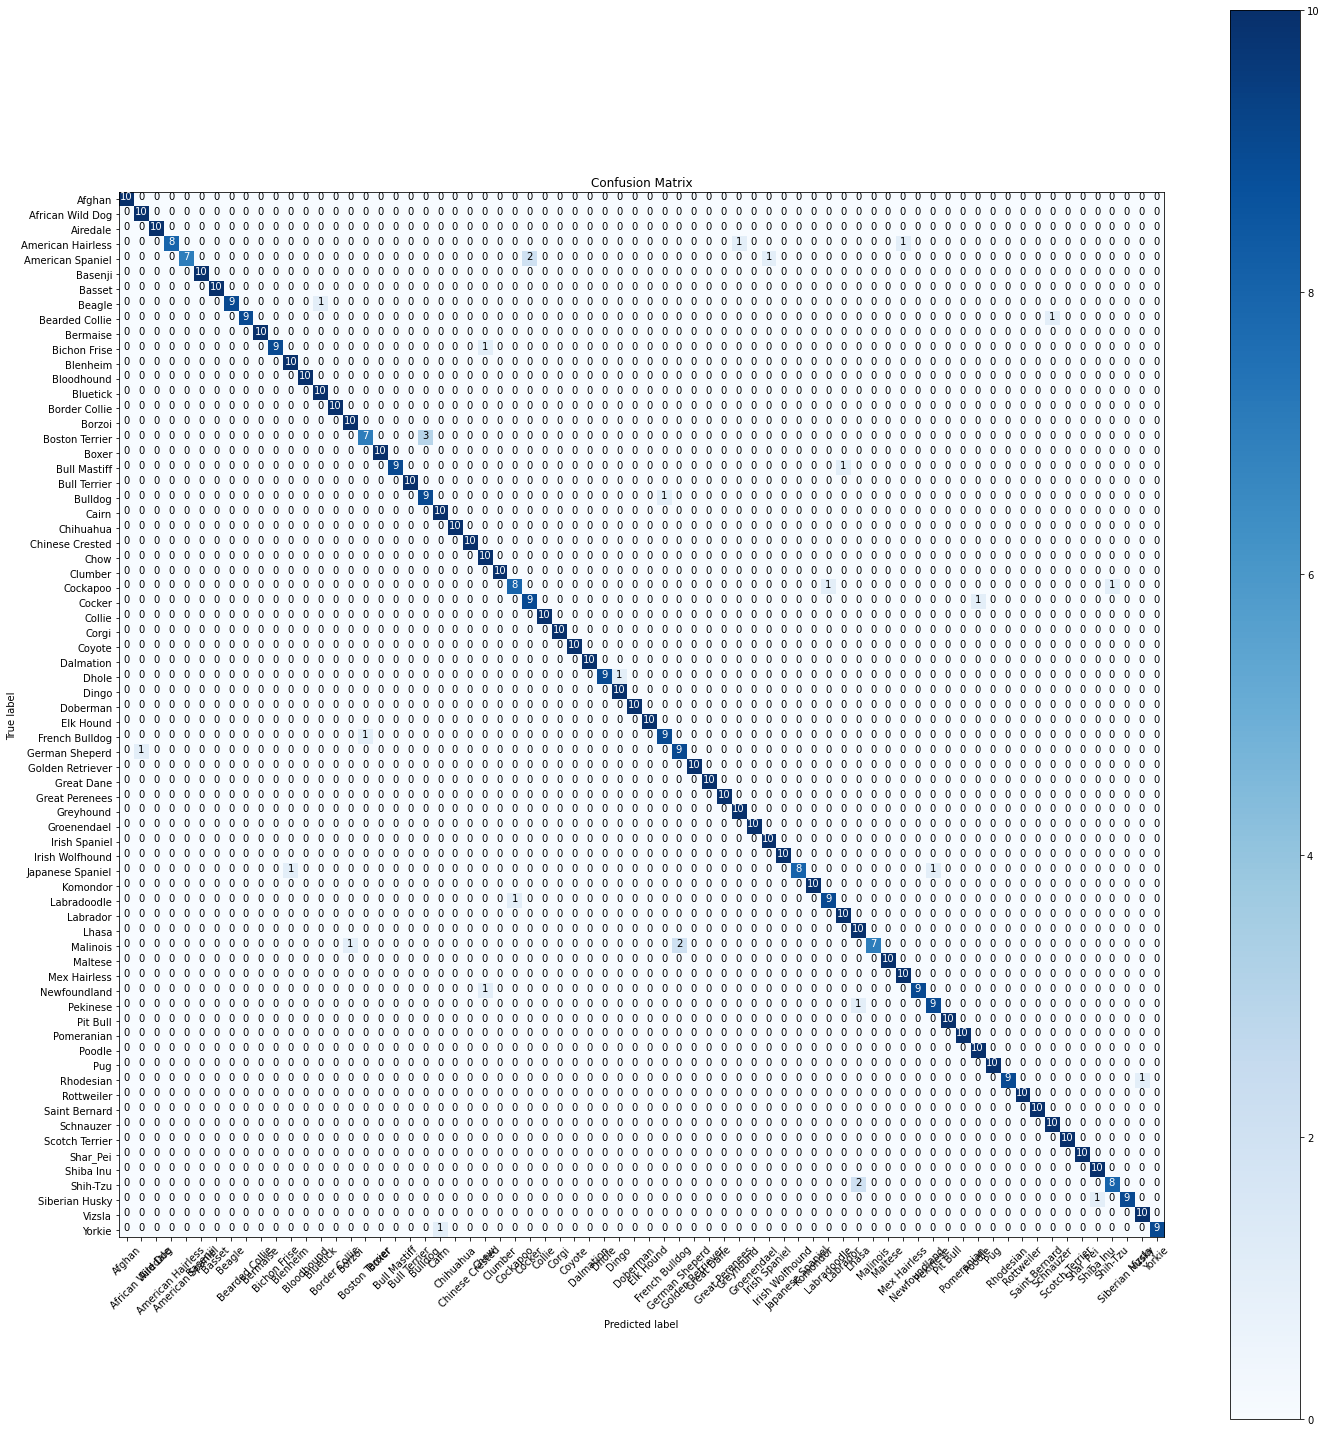

In [34]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Afghan','African Wild Dog','Airedale','American Hairless','American Spaniel','Basenji','Basset','Beagle','Bearded Collie','Bermaise','Bichon Frise','Blenheim','Bloodhound','Bluetick','Border Collie','Borzoi','Boston Terrier','Boxer','Bull Mastiff','Bull Terrier','Bulldog','Cairn','Chihuahua','Chinese Crested','Chow','Clumber','Cockapoo','Cocker','Collie','Corgi','Coyote','Dalmation','Dhole','Dingo','Doberman','Elk Hound','French Bulldog','German Sheperd','Golden Retriever','Great Dane','Great Perenees','Greyhound','Groenendael','Irish Spaniel','Irish Wolfhound','Japanese Spaniel','Komondor','Labradoodle','Labrador','Lhasa','Malinois','Maltese','Mex Hairless','Newfoundland','Pekinese','Pit Bull','Pomeranian','Poodle','Pug','Rhodesian','Rottweiler','Saint Bernard','Schnauzer','Scotch Terrier','Shar_Pei','Shiba Inu','Shih-Tzu','Siberian Husky','Vizsla','Yorkie']
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [35]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [36]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

                   precision    recall  f1-score   support

           Afghan       1.00      1.00      1.00        10
 African Wild Dog       0.91      1.00      0.95        10
         Airedale       1.00      1.00      1.00        10
American Hairless       1.00      0.80      0.89        10
 American Spaniel       1.00      0.70      0.82        10
          Basenji       1.00      1.00      1.00        10
           Basset       1.00      1.00      1.00        10
           Beagle       1.00      0.90      0.95        10
   Bearded Collie       1.00      0.90      0.95        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       1.00      0.90      0.95        10
         Blenheim       0.91      1.00      0.95        10
       Bloodhound       1.00      1.00      1.00        10
         Bluetick       0.91      1.00      0.95        10
    Border Collie       1.00      1.00      1.00        10
           Borzoi       0.91      1.00      0.95       